# Imports

In [43]:
%matplotlib inline

import time
import os
import cv2
import random
import imageio

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd

from tqdm import tqdm
from io import BytesIO

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Global variables

In [44]:
OS = "windows"
valid_size = 0.2
# label_name = ["palm_horizontal", "L", "fist_horizontal", "fist_vertical", "thumb_up", "index", "ok", "palm_vertical", "C", "thumb_down"]

# Loading data

In [45]:
def load_labelling_data():
    X = []
    y = []
    if OS == "windows":
        split_ = "\\"
    else:
        split_ = "/"
    for root, _, files in tqdm(os.walk("../", topdown=False)): 
        for name in files:
            path = os.path.join(root, name)
            if path.endswith("jpg"):
                # if path.split(split_)[-1][0] != ".":
                if path.split(split_)[-1][0].isalpha():
                    # Loading images
                    img = cv2.imread(path)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    X.append(img)
                    # Loading labels
                    category = path.split(split_)[-1].split("_")[0]
                    # label = int(category.split("_")[0]) - 1
                    y.append(category)
    X = np.array(X)
    y = np.array(y)
    return X[:,:,:,np.newaxis], y

def load_test_data(width, height):
    X = []
    if OS == "windows":
        split_ = "\\"
    else:
        split_ = "/"
    for root, _, files in tqdm(os.walk("../", topdown=False)): 
        for name in files:
            path = os.path.join(root, name)
            if path.endswith("jpg"):
                # if path.split(split_)[-1][0] != ".":
                if not path.split(split_)[-1][0].isalpha() and path.split(split_)[-1][0] != ".":
                    # Loading images
                    img = cv2.imread(path)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    img = cv2.resize(img, (width, height))
                    X.append(img)
    X = np.array(X)
    return X.reshape(X.shape[0], height, width, 1)

def get_background_images():
	images = []
	vidcap = cv2.VideoCapture('data_background/test.mkv')
	success,image = vidcap.read()
	while success:
		img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)[:,:,np.newaxis]
		images.append(img)
		success, image = vidcap.read()
	return np.array(images)

# def load_dataset_data(width, height):
#     X = []
#     y = []
#     if OS == "windows":
#         split_ = "\\"
#     else:
#         split_ = "/"
#     for root, dirs, files in tqdm(os.walk(".", topdown=False)): 
#         for name in files:
#             path = os.path.join(root, name)
#             if path.endswith("png"):
#                 # Loading labels
#                 category = path.split(split_)[4]
#                 label = int(category.split("_")[0]) - 1
#                 y.append(label)
#                 # Loading images
#                 img = cv2.imread(path)
#                 img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#                 img = cv2.resize(img, (width, height))
#                 X.append(img)
#     X = np.array(X)
#     y = np.array(y)
#     return X.reshape(X.shape[0], height, width, 1), y

In [46]:
X_labelling, y_labelling = load_labelling_data()
background_images = get_background_images()[::10]

128it [00:00, 963.21it/s]


In [47]:
print(X_labelling.shape)
print(y_labelling.shape)
print(background_images.shape)

(99, 100, 100, 1)
(99,)
(145, 720, 960, 1)


# Data augmentation

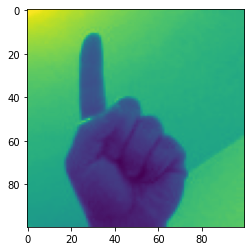

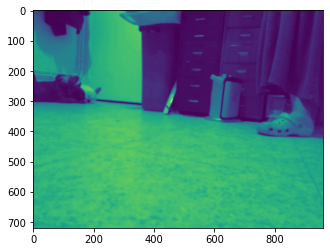

In [48]:
plt.imshow(X_labelling[0])
plt.show()
plt.imshow(background_images[0])
plt.show()

In [49]:
def fill(img, h, w):
    img = cv2.resize(img, (h, w), cv2.INTER_CUBIC)
    return img
        
def horizontal_shift(img, ratio=0.0):
    if ratio > 1 or ratio < 0:
        return img
    ratio = random.uniform(-ratio, ratio)
    h, w = img.shape[:2]
    to_shift = w*ratio
    if ratio > 0:
        img = img[:, :int(w-to_shift), :]
    if ratio < 0:
        img = img[:, int(-1*to_shift):, :]
    img = fill(img, h, w)
    return img

def vertical_shift(img, ratio=0.0):
    if ratio > 1 or ratio < 0:
        return img
    ratio = random.uniform(-ratio, ratio)
    h, w = img.shape[:2]
    to_shift = h*ratio
    if ratio > 0:
        img = img[:int(h-to_shift), :, :]
    if ratio < 0:
        img = img[int(-1*to_shift):, :, :]
    img = fill(img, h, w)
    return img

def brightness(img, low, high):
    value = random.uniform(low, high)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hsv = np.array(hsv, dtype = np.float64)
    hsv[:,:,1] = hsv[:,:,1]*value
    hsv[:,:,1][hsv[:,:,1]>255]  = 255
    hsv[:,:,2] = hsv[:,:,2]*value 
    hsv[:,:,2][hsv[:,:,2]>255]  = 255
    hsv = np.array(hsv, dtype = np.uint8)
    img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return img

def zoom(img, value):
    if value > 1 or value < 0:
        return img
    value = random.uniform(value, 1)
    h, w = img.shape[:2]
    h_taken = int(value*h)
    w_taken = int(value*w)
    h_start = random.randint(0, h-h_taken)
    w_start = random.randint(0, w-w_taken)
    img = img[h_start:h_start+h_taken, w_start:w_start+w_taken, :]
    img = fill(img, h, w)
    return img

def channel_shift(img, value):
    value = int(random.uniform(-value, value))
    img = img + value
    img[:,:,:][img[:,:,:]>255]  = 255
    img[:,:,:][img[:,:,:]<0]  = 0
    img = img.astype(np.uint8)
    return img.squeeze()

def horizontal_flip(img, flag):
    if flag:
        return cv2.flip(img, 1)
    else:
        return img

def vertical_flip(img, flag):
    if flag:
        return cv2.flip(img, 0)
    else:
        return img

def rotation(img, angle):
    angle = int(random.uniform(-angle, angle))
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((int(w/2), int(h/2)), angle, 1)
    img = cv2.warpAffine(img, M, (w, h))
    return img

def get_augmented_images(X, y):
	X_augmented = []
	y_augmented = []
	for i in range(X.shape[0]):
		X_augmented.append(X[i].squeeze())
		y_augmented.append(y[i])
		X_augmented.append(horizontal_shift(X[i], 0.7))
		y_augmented.append(y[i])
		X_augmented.append(vertical_shift(X[i], 0.7))
		y_augmented.append(y[i])
		# X_augmented.append(brightness(X[i], 0.5, 3))
		# y_augmented.append(y[i])
		X_augmented.append(zoom(X[i], 0.5))
		y_augmented.append(y[i])
		X_augmented.append(channel_shift(X[i], 60))
		y_augmented.append(y[i])
		# X_augmented.append(horizontal_flip(X[i], True))
		# y_augmented.append(y[i])
		# X_augmented.append(vertical_flip(X[i], True))
		# y_augmented.append(y[i])
		X_augmented.append(rotation(X[i], 20))
		y_augmented.append(y[i])
		X_augmented.append(rotation(X[i], 40))
		y_augmented.append(y[i])
		X_augmented.append(rotation(X[i], -20))
		y_augmented.append(y[i])
		X_augmented.append(rotation(X[i], -40))
		y_augmented.append(y[i])
	return np.array(X_augmented), np.array(y_augmented)

def add_background_to_data(background_images, hand_images, labels):
    final_images = []
    new_labels = []
    for idx, hand_img in enumerate(tqdm(hand_images)):
        for background_img in background_images:
            for r in range(1, 4):
                resize = int(hand_img.shape[0]*r)
                hand_img_resized = cv2.resize(hand_img, (resize, resize))[:,:,np.newaxis]
                y_offset = np.random.randint(background_img.shape[0] - hand_img_resized.shape[0])
                x_offset = np.random.randint(background_img.shape[1] - hand_img_resized.shape[1])
                tmp = background_img.copy()
                tmp[y_offset:y_offset+hand_img_resized.shape[0], x_offset:x_offset+hand_img_resized.shape[1]] = hand_img_resized
                tmp = cv2.resize(tmp, (128, 128))[:,:,np.newaxis]
                final_images.append(tmp)
                new_labels.append(labels[idx])
    return np.array(final_images), np.array(new_labels)

In [50]:
X_labelling_augmented, y_labelling_augmented = get_augmented_images(X_labelling, y_labelling)

In [51]:
print(X_labelling_augmented.shape)
print(y_labelling_augmented.shape)

(891, 100, 100)
(891,)


In [52]:
X, y = add_background_to_data(background_images, X_labelling_augmented, y_labelling_augmented)
print(X.shape)
print(y.shape)

100%|██████████| 891/891 [00:51<00:00, 17.41it/s]


(387585, 128, 128, 1)
(387585,)


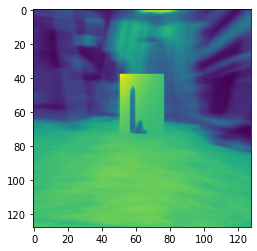

In [53]:
plt.imshow(X[1000])

In [54]:
label_names, y = np.unique(y, return_inverse=True) ## Converts to categorical int and get label names
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=valid_size, random_state=42)

In [66]:
X_train.shape

X_train, X_valid, y_train, y_valid = X_train[::15], X_valid[::15], y_train[::15], y_valid[::15] 

# Building model

In [67]:
def build_model():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(32, (5, 5), activation='relu', input_shape=(X_train[0].shape))) 
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu')) 
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Dropout(rate=0.2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dense(len(label_names), activation='softmax'))
    return model

# Training model

In [70]:
train_ = False

if train_ :
    model = build_model()
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=5, batch_size=256, verbose=2, validation_data=(X_valid, y_valid))
    model.save('tmp_model.h5')
else:
    model = tf.keras.models.load_model("best_model.h5", custom_objects=None, compile=True, options=None)

model.summary()
valid_loss, valid_acc = model.evaluate(X_valid, y_valid)
print('Valid accuracy: {:2.2f}%'.format(valid_acc*100))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 32)      832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0

# Inference

In [ ]:
if train_:
	# summarize history for accuracy
	plt.plot(history.history['accuracy'])
	plt.plot(history.history['val_accuracy'])
	plt.title('model accuracy')
	plt.ylabel('accuracy')
	plt.xlabel('epoch')
	plt.legend(['train', 'valid'], loc='upper left')
	plt.show()
	# summarize history for loss
	plt.plot(history.history['loss'])
	plt.plot(history.history['val_loss'])
	plt.title('model loss')
	plt.ylabel('loss')
	plt.xlabel('epoch')
	plt.legend(['train', 'valid'], loc='upper left')
	plt.show()

In [ ]:
X_test = load_test_data(128, 128)

128it [00:01, 65.72it/s]


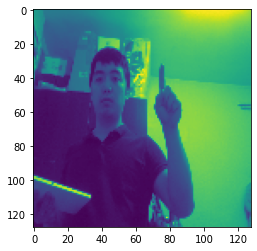

In [ ]:
plt.imshow(X_test[0])
plt.show()

In [ ]:
preds = np.argmax(model.predict(X_test), axis=1)
label_names

array(['FINGER', 'FIST', 'LEFT', 'PALM', 'RIGHT'], dtype='<U6')

In [ ]:
# for i in range(len(preds)):
#     print("=======================================")
#     plt.imshow(X_test[i])
#     plt.show()
#     print(label_names[preds[i]])

In [63]:
inference_ = True

if inference_ :
	cv2.destroyAllWindows()
	before = time.time()
	vid = cv2.VideoCapture(1)
	while True:

		ret, frame = vid.read()
		cv2.imshow('frame', frame)
		if cv2.waitKey(1) & 0xFF == ord('q'):
			break
		img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
		img = cv2.resize(img, (128, 128))
		img = img.reshape(1, 128, 128, 1)

		after = int(time.time() - before)
		print(label_names[np.argmax(model.predict(img))], end='\r')

	vid.release()
	cv2.destroyAllWindows()